In [12]:
import os, warnings
from dataclasses import dataclass
from typing import Optional, Tuple
import numpy as np, pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

import matplotlib.pyplot as plt
from IPython.display import display

def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)

def section(t): 
    print("\n"+"="*80)
    print(t)
    print("="*80)


In [13]:
def sigmoid(z):
    z = np.clip(z, -500, 500)
    return 1/(1+np.exp(-z))

def sigmoid_deriv(z):
    s = sigmoid(z)
    return s*(1-s)

@dataclass
class ScratchNNConfig:
    n_hidden:int=20
    learning_rate:float=0.1
    n_iter:int=1000

def train_scratch_nn(X,y,cfg):
    m,n=X.shape
    W1=np.random.randn(n,cfg.n_hidden)*0.01; b1=np.zeros((1,cfg.n_hidden))
    W2=np.random.randn(cfg.n_hidden,1)*0.01; b2=np.zeros((1,1))
    y=y.reshape(-1,1)
    for i in range(1,cfg.n_iter+1):
        Z2=X@W1+b1; A2=sigmoid(Z2)
        Z3=A2@W2+b2; A3=Z3
        dZ3=A3-y; dW2=A2.T@dZ3; db2=np.sum(dZ3,0,keepdims=True)
        dZ2=(dZ3@W2.T)*sigmoid_deriv(Z2)
        dW1=X.T@dZ2; db1=np.sum(dZ2,0,keepdims=True)
        W2-=cfg.learning_rate*dW2/m; b2-=cfg.learning_rate*db2/m
        W1-=cfg.learning_rate*dW1/m; b1-=cfg.learning_rate*db1/m
        if i%100==0:
            mse=np.mean((y-A3)**2)
            print(f"Iter {i}, Train MSE: {mse:.3f}")
    return {"W1":W1,"b1":b1,"W2":W2,"b2":b2}

def predict_scratch_nn(X,model):
    A2=sigmoid(X@model["W1"]+model["b1"])
    return (A2@model["W2"]+model["b2"]).ravel()


In [14]:
from sklearn import datasets

def load_housing():
    scaler=StandardScaler()
    try:
        boston=datasets.load_boston()
        X,y=boston.data,boston.target
        print("Loaded Boston dataset.")
    except Exception:
        cal=datasets.fetch_california_housing()
        X,y=cal.data,cal.target*100
        print("Loaded California dataset (fallback).")
    Xtr,Xte,ytr,yte=X[:-10],X[-10:],y[:-10],y[-10:]
    Xtr=scaler.fit_transform(Xtr); Xte=scaler.transform(Xte)
    return Xtr,Xte,ytr,yte

def sklearn_mlp(Xtr,Xte,ytr,yte):
    nn=MLPRegressor(hidden_layer_sizes=(16,8),activation='relu',
                    solver='adam',max_iter=2000,random_state=42)
    nn.fit(Xtr,ytr)
    pred=nn.predict(Xte)
    print("sklearn MLP MSE:",mean_squared_error(yte,pred))
    return pred

def keras_housing(Xtr,Xte,ytr,yte,epochs=300):
    model=Sequential([
        Dense(20,activation='relu'),Dropout(0.2),
        Dense(8,activation='relu'),Dense(1)
    ])
    model.compile(loss='mse',optimizer=keras.optimizers.Adam(0.02))
    es=keras.callbacks.EarlyStopping(monitor="val_loss",patience=25,restore_best_weights=True)
    model.fit(Xtr,ytr,validation_data=(Xte,yte),epochs=epochs,verbose=0,callbacks=[es])
    pred=model.predict(Xte).ravel()
    print("Keras MSE:",mean_squared_error(yte,pred))
    return pred,model


In [15]:
def infer_cols(df):
    mapping={'open':['Open','OPEN'],'high':['High','HIGH'],
             'low':['Low','LOW'],'close':['Close','CLOSE','Adj Close'],
             'volume':['Volume','VOLUME','Vol']}
    for std,alts in mapping.items():
        if std not in df.columns:
            for a in alts:
                if a in df.columns:
                    df[std]=df[a]; break
    return df

def make_features(df):
    d=infer_cols(df).sort_index()
    d['ret1']=d['close'].pct_change()
    for k in [1,3,5,10]: d[f'lag{k}']=d['close'].shift(k)
    for w in [5,10,20]:
        d[f'mean{w}']=d['close'].rolling(w).mean()
        d[f'std{w}']=d['close'].rolling(w).std()
    d=d.dropna()
    feats=[c for c in d.columns if c!='close']
    return d[feats+['close']]

def keras_stock(Xtr,ytr,Xval,yval,epochs=300):
    model=Sequential([
        Dense(32,activation='relu'),Dropout(0.2),
        Dense(16,activation='relu'),Dense(1)
    ])
    model.compile(loss='mse',optimizer=keras.optimizers.Adam(0.01))
    es=keras.callbacks.EarlyStopping(monitor="val_loss",patience=30,restore_best_weights=True)
    model.fit(Xtr,ytr,validation_data=(Xval,yval),epochs=epochs,verbose=0,callbacks=[es])
    return model

def show_plot(dates,true,pred,title):
    fig,ax=plt.subplots(figsize=(10,5))
    ax.plot(dates,true,label="Actual")
    ax.plot(dates,pred,label="Predicted")
    ax.set_title(title); ax.set_xlabel("Date"); ax.set_ylabel("Close")
    ax.legend(); fig.tight_layout()
    display(fig)
    plt.close(fig)


In [17]:
import os

def find_stock_csv(user_path: Optional[str] = None):
    """
    Return (resolved_path, DataFrame) for the first readable CSV found.
    Search order:
      1) user_path (if provided)
      2) current working dir: 19880101_20191231.csv, 20051201_20051210.csv
      3) /mnt/data/: same two names
    """
    candidates = []
    if user_path:
        candidates.append(user_path)

    # Common names in CWD
    candidates += [
        "19880101_20191231.csv",
        "20051201_20051210.csv",
    ]
    # Common names under /mnt/data
    candidates += [
        "/mnt/data/19880101_20191231.csv",
        "/mnt/data/20051201_20051210.csv",
    ]

    for path in candidates:
        if path and os.path.exists(path) and os.path.isfile(path):
            try:
                df = pd.read_csv(path)
                print(f"✔ Using CSV: {path}")
                return path, df
            except Exception as e:
                print(f"Skipping {path}: {e}")

    # If nothing found, print helpful diagnostics
    print("✘ Could not locate a stock CSV. Checked:")
    for p in candidates:
        print("   -", p)
    print("\nTip: Put the CSV in the same folder as the notebook or pass stock_csv='path'.")
    return None, None



Part 1 — Scratch NN (Housing)
Loaded California dataset (fallback).
Iter 100, Train MSE: 4880.961
Iter 200, Train MSE: 4247.986
Iter 300, Train MSE: 4057.723
Iter 400, Train MSE: 3779.243
Iter 500, Train MSE: 3839.021
Iter 600, Train MSE: 3770.575
Iter 700, Train MSE: 3539.605
Iter 800, Train MSE: 3640.213
Iter 900, Train MSE: 3480.511
Iter 1000, Train MSE: 3515.420
Scratch NN MSE: 128.07770372781368

Part 2 — sklearn MLP
sklearn MLP MSE: 119.73137393282632

Part 3 — Keras Housing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Keras MSE: 64.86102718591783

Part 4 — Stock Prediction
✔ Using CSV: 19880101_20191231.csv
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step
Stock MSE: 40955.26720610057 | MAE: 179.43492294320998 | R²: 0.9973991902779021


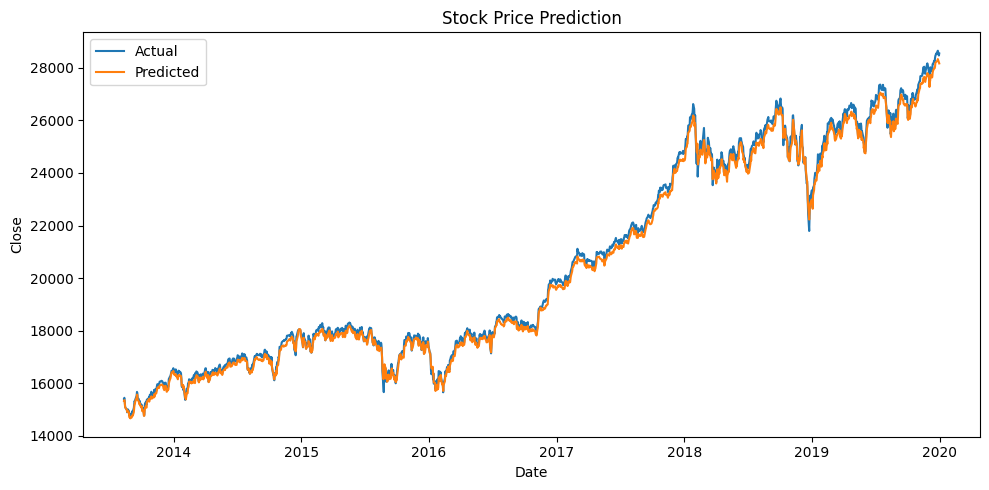


Done


In [18]:
def main(stock_csv: Optional[str] = None, epochs=300):
    set_seed()
    section("Part 1 — Scratch NN (Housing)")
    Xtr,Xte,ytr,yte=load_housing()
    model=train_scratch_nn(Xtr,ytr,ScratchNNConfig())
    pred=predict_scratch_nn(Xte,model)
    print("Scratch NN MSE:",mean_squared_error(yte,pred))

    section("Part 2 — sklearn MLP")
    sklearn_mlp(Xtr,Xte,ytr,yte)

    section("Part 3 — Keras Housing")
    keras_housing(Xtr,Xte,ytr,yte,epochs)

    section("Part 4 — Stock Prediction")
    try:
        # --- NEW: auto-find the CSV ---
        path, df = find_stock_csv(stock_csv)
        if df is None:
            raise FileNotFoundError("No stock CSV found. Pass stock_csv='your/path.csv' or place it next to the notebook.")

        # Detect a date column (if any) and index by it
        date_col = None
        for c in df.columns:
            if 'date' in c.lower():
                date_col = c; break
        if date_col:
            df[date_col] = pd.to_datetime(df[date_col])
            df = df.set_index(date_col)
        else:
            # fallback to a business-day index to keep the pipeline running
            df.index = pd.date_range(start="2000-01-01", periods=len(df), freq="B")

        data = make_features(df)
        scaler = StandardScaler()
        X = scaler.fit_transform(data.drop(columns=['close']))
        y = data['close'].values

        # chronological split: 70% train, 10% val, 20% test
        split = int(0.8 * len(X))
        Xtr, Xval, Xte = X[:int(0.7*split)], X[int(0.7*split):split], X[split:]
        ytr, yval, yte = y[:int(0.7*split)], y[int(0.7*split):split], y[split:]

        model = keras_stock(Xtr,ytr,Xval,yval,epochs)
        pred = model.predict(Xte).ravel()
        print("Stock MSE:",mean_squared_error(yte,pred),
              "| MAE:",mean_absolute_error(yte,pred),
              "| R²:",r2_score(yte,pred))

        # Show plot inline (no %matplotlib needed)
        show_plot(data.index[-len(yte):], yte, pred, "Stock Price Prediction")
    except Exception as e:
        print("Stock part failed:", e)

    section("Done")

# Run with auto-detection
main()
